In [1]:
from pyspark import SparkContext
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.feature import IDF
from pyspark.ml.feature import StopWordsRemover
import math

In [2]:
sc = SparkContext(appName="Teste")

In [3]:
rdd = sc.sequenceFile("pages/part-00000")
# rdd = rdd.map(lambda line: line.split(" "))
# rdd = rdd.map(lambda line: line[1:][0:])
# # documents = rdd.map(lambda line: (line[0], line[1:]))
# documents = documents.map(lambda line: line[1:][0])


In [4]:
#total de documentos na base
total_docs = rdd.count()
total_docs

36133

In [5]:
#Conta quantos docs cada palavra aparece
def conta_docs(item):
    texto = item[1]
    palavras = texto.strip().split()
    return [(palavra.lower(),1) for palavra in set(palavras)]
rdd_docs_word = rdd.flatMap(conta_docs).reduceByKey(lambda x,y: x + y).cache()

In [6]:
word_freq = rdd_docs_word.collect()

In [48]:
#Palavras que aparecem em mais docs -> (palavra, quantidade de docs)
sorted_freq = sorted(word_freq, key=lambda x: -x[1])

In [35]:
sorted_freq[:10]

NameError: name 'sorted_freq' is not defined

In [7]:
#Filtra palavras que aparecem em certa quantidade de docs
doc_freq_min = 5
doc_freq_max = 0.7 * total_docs
def filtra(item):
    contagem = item[1]
    return (contagem < doc_freq_max) and (contagem > doc_freq_min)

rdd_freq_docs_filtrado = rdd_docs_word.filter(filtra)

In [8]:
#Calcula idf de cada palavra filtrada
def computa_idf(item):
    palavra, contagem = item
    idf = math.log10(total_docs / contagem)
    return (palavra, idf)
rdd_idf = rdd_freq_docs_filtrado.map(computa_idf)

In [11]:
result = rdd_idf.collect()

In [ ]:
result

In [9]:
#ordenar idfs
#sorted_ = sorted(result, key=lambda x: x[1])

def get_word(item):
    palavra, idf = item
    return [palavra]
rdd_words = rdd_idf.flatMap(get_word)
rdd_words_collect = rdd_words.collect()

In [10]:
#Quantas ocorrencias da palavra em todos documentos
def conta_palavras(item):
    texto = item[1]
    palavras = texto.strip().split()
    return [(palavra.lower(),1) for palavra in palavras]

rdd_words_count = rdd.flatMap(conta_palavras).reduceByKey(lambda x,y: x + y).cache()

In [ ]:
#Frequencia de cada palavra
def computa_freq(item):
    
    palavra, contagem = item
    if palavra in rdd_words_collect:
        freq = math.log10(1 + contagem)
        return (palavra, freq)
    else:
        return ()

rdd_freq = rdd_words_count.map(computa_freq)
result2 = rdd_freq.collect()
# def computa_relevancia(item):
    

In [29]:
#Quantidade de docs que a palavra aparece
def check_word(item):
    url, texto = item
    if "toyota" in texto:
        return [url]
    else:
        return []
rdd_url = rdd.flatMap(check_word)

In [30]:
count_word_docs = rdd_url.cache().count()

In [14]:
#Documentos em que a palavra recebe
rdd_url_collect = rdd_url.collect()

In [30]:
for url in rdd_url_collect:
    print(url)

http://decioadams.netspa.com.br/tag/concurso/
https://www.gazetadopovo.com.br/haus/design/toyota-lanca-desafio-reinventa-cadeira-rodas/?fbclid=IwAR3XRp8BHPY___Izd9mckQ8Nv1bw09e4N-g9t4zVlLnVPaZVCvdkluJjY74
https://www.mecanicafirecar.com.br/embreagem/embreagem-carros-a-gasolina/embreagem-motor-a-diesel-americanopolis
https://carsale.uol.com.br/2019/04/26/freio-de-duster-e-oroch-pode-travar-e-renault-anuncia-recall
https://www.cabecacar.com.br/parachoque-traseiro-pick-up-corsa-95-96-97-98-99-00-01-02-pr-4762-302232.htm
https://motorshow.com.br/tag/toyota-hilux/
https://www.bulloleo.com.br/bora?map=specificationFilter_120
https://www.car.blog.br/2018/11/mais-vendidos-alemanha-vw-golf-mantem.html?showComment=1541846353217
https://carsale.uol.com.br/palavras-chave/ford/page/16
https://motor1.uol.com.br/news/117579/toyota-se-rende-ao-downsizing-e-promete-motores-ate-30-mais-eficientes/
https://carsale.uol.com.br/2017/02/24/ford-revela-o-novo-fiesta-st-com-motor-1-5-turbo-de-200-cv-e-desativa

36133

In [20]:
hashingTF = HashingTF()
tf = hashingTF.transform(rdd)

In [21]:
#Tabela de frequencia inversa 1048576
tf.cache()
idf = IDF().fit(tf)
tfidf = idf.transform(tf)

#After we got the tf-idf, we can used it to find the most related article using keyword. 
#We need add this code to find the most related article with keyword.
# keywordTF = hashingTF.transform([keyword.lower()])
# keywordHashValue = int(keywordTF.indices[0])

In [22]:
#Tabela com frequencia minima
tf.cache()
idfIgnore = IDF(minDocFreq=2).fit(tf)
tfidfIgnore = idfIgnore.transform(tf)

In [48]:
print("tfidf:")
for each in tfidf.collect():
    print(each)

tfidf:
(1048576,[1475,1850,4561,4680,5025,5133,7775,8395,9062,11977,12057,12139,13862,16911,17904,20972,21078,21261,22352,22649,22699,24286,27527,28076,28088,29395,30491,30910,31692,32823,33913,35539,35877,36289,39097,39841,39983,40203,43015,45832,47883,50421,51155,51841,52512,53554,54363,54541,58089,61044,61288,62816,63749,64706,65485,65960,67405,67549,69071,69382,69478,69662,70939,71981,76012,76221,76867,79288,79335,79792,82242,84517,86710,90318,93890,99295,101141,101786,103153,103693,104701,105437,108707,112979,113415,115881,116313,117738,118315,119289,120049,120216,120308,120734,121471,121699,123523,124127,124334,125007,125195,126213,126511,127190,128183,128252,131842,131871,132630,134019,134325,134903,136221,137026,138953,140118,140256,140753,140954,142714,145577,147057,147235,147443,147781,151026,151034,151160,151696,152086,153870,156679,156829,159071,160698,161662,161870,162901,165111,165567,166932,167915,168798,168865,168887,169161,172368,172864,173013,173242,173459,173865,1759

[["('http://carta.fee.tche.br/article/crise-fiscal-incentivos-e-o-desenvolvimento-do-rs/',",
  "'Crise",
  'fiscal,',
  'incentivos',
  'e',
  'o',
  'desenvolvimento',
  'do',
  'RS',
  '|',
  '|',
  'Carta',
  'de',
  'Conjuntura\\nCarta',
  'de',
  'Conjuntura',
  'FEE\\nMenu\\nSEPLAG/RS\\t\\nApresentação\\nNúmero',
  'Atual\\nTodas',
  'as',
  'edições\\nCrise',
  'fiscal,',
  'incentivos',
  'e',
  'o',
  'desenvolvimento',
  'do',
  'RS\\nPor:',
  'Alexandre',
  'Alves',
  'Porsse\\nEdição:',
  'Ano',
  '16',
  'nº',
  '10',
  '-',
  '2007\\nÁrea',
  'temática:',
  'Economia\\nAssunto(s):',
  'condições',
  'econômicas,',
  'impostos,',
  'Rio',
  'Grande',
  'do',
  'Sul\\nO',
  'envio,',
  'pelo',
  'Executivo,',
  'da',
  'proposta',
  'orçamentária',
  'de',
  '2008',
  'à',
  'Assembléia',
  'Legislativa,',
  'prevendo',
  'um',
  'déficit',
  'de',
  'R$',
  '1,3',
  'bilhão,',
  'representa',
  'uma',
  'mudança',
  'na',
  'política',
  'de',
  'enfrentamento',
  'da',
  
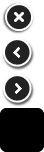

In [47]:
rdd.collect()

NameError: name 'numberofdocs_word' is not defined